Mathematics for AI Assignment

Group 3

<!-- table -->

| Name                   | ID          |
| ---------------------- | ----------- |
| Yanet Mekuria Guangul  | UGR/7313/13 |
| Feven Tesfaye Tilahun  | UGR/7905/13 |
| Gelila Moges Shenkutie | UGR/5888/13 |
| Amanuel Beyene Reta    | UGR/1157/13 |
| Gedion Ezra Abate      | UGR/0448/13 |
| Nathnael Dereje Arega  | UGR/8587/13 |


# Eigenfaces Face Recognition

## Importing Libraries

In [1]:
import glob
import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

## Read Images
Load the train dataset and read images for training.

In [2]:
path_to_images = "/dataset/train_images/*.*.jpg"  # path to the training images
path = os.getcwd()
images_path =  glob.glob(path + path_to_images)

# form a dictionary of images with the key as the image name
images = [mpimg.imread(file) for file in images_path]

# read the images
print("Number of images: ", len(images))
print("Shape of the images: ", images[0].shape)

Number of images:  100
Shape of the images:  (243, 320)


## Crop Images

Resize images to make them N x N, where N is 130 in this case.


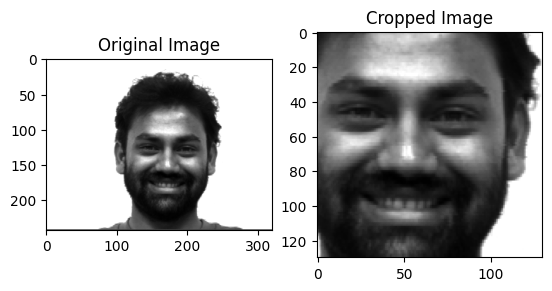

Original Dimension (243, 320)
Cropped Dimension (130, 130)


In [4]:
# crop the images into an N x N square
dimensions = (80, 210, 120, 250)
startx, endx, starty, endy = dimensions

# crop the images
images_cropped = [image[startx:endx, starty:endy] for image in images]

# make room for all the images
fig, ax = plt.subplots(1, 2)

random_image = np.random.randint(0, len(images))

# plot the original image
ax[0].imshow(images[random_image], cmap="gray")
ax[0].set_title("Original Image")

# plot the cropped image
ax[1].imshow(images_cropped[random_image], cmap="gray")
ax[1].set_title("Cropped Image")

# display the plot
plt.show()

print("Original Dimension", images[0].shape)
print("Cropped Dimension", images_cropped[0].shape)

## Flatten the images


In [5]:
# Now we flatten the images
images_flattened = [image.flatten() for image in images_cropped]

# vectorize
images_flattened = np.array(images_flattened)

print("Dimension of the flattened image: ", images_flattened[0].shape)

Dimension of the flattened image:  (16900,)


## Compute Mean Face and Subtract from each image


In [6]:
# Now we normalize the images
mean_face = images_flattened.mean(axis=0)

# subtract the mean face from the images
images_normalized = images_flattened - mean_face

## Computing Covariance

Instead of computing the covariance matrix of the normal images, we can compute for the transpose of the matrix. This is because the covariance matrix of a matrix and its transpose are the same. This is also more efficient since the matrix is smaller.

In [7]:
# Now we compute the covariance matrix: here instead of the normal covariance matrix,
# we use the transpose of the matrix

covariance_matrix = np.cov(images_normalized.T, rowvar=False)
print(covariance_matrix.shape)

(100, 100)


## Compute Eigenvalues and Eigenvectors


In [8]:
# Now we compute the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

# Now we convert eigenvectors to the not transposed version by multiplying it with the normalized images
eigenvectors = np.dot(images_normalized.T, eigenvectors)

## Select the top k eigenvectors


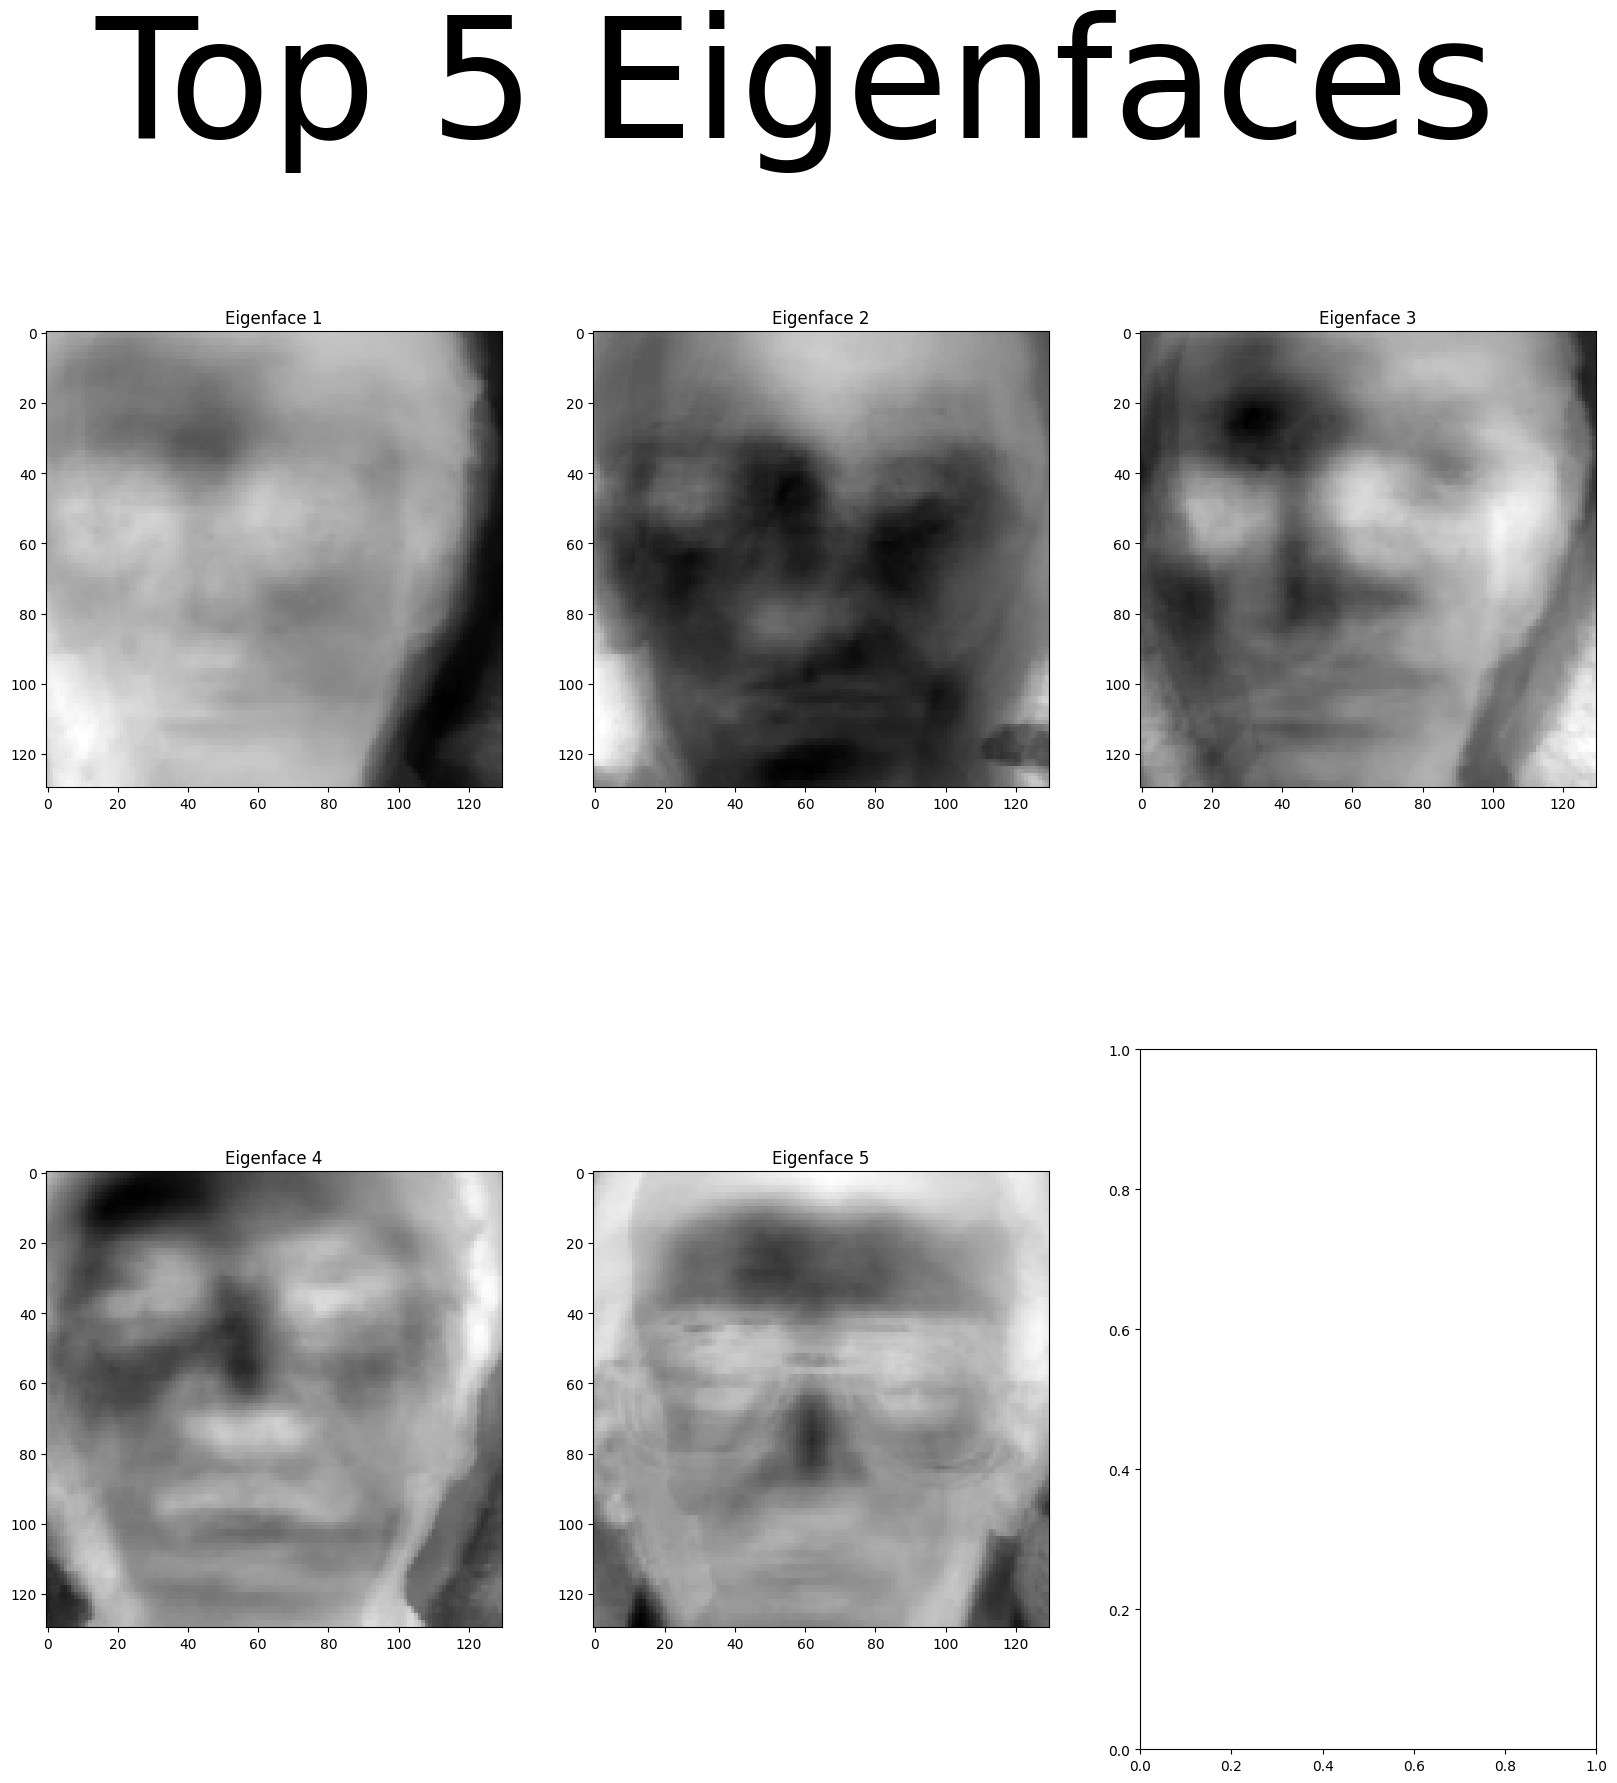

In [9]:
# Select the top K eigenvectors
K = 100

# select the top K eigenvectors by eigenvalues
zip_eigenvalues_eigenvectors = zip(eigenvalues, eigenvectors.T)
sorted_zip = sorted(zip_eigenvalues_eigenvectors, key=lambda x: x[0], reverse=True)
sorted_eigenvalues, sorted_eigenvectors = zip(*sorted_zip)
sorted_eigenvalues = np.array(sorted_eigenvalues)
sorted_eigenvectors = np.array(sorted_eigenvectors)
top_K_eigenvectors = sorted_eigenvectors[:K, :]

# let's see what the eigenfaces look like
fig, ax = plt.subplots(2, 3, figsize=(20, 20))

# write top 5 eigenfaces in plot
fig.suptitle("Top 5 Eigenfaces", fontsize=120)

for i in range(5):
    ax[i//3, i%3].imshow(top_K_eigenvectors[i].reshape(130, 130), cmap="gray")
    ax[i//3, i%3].set_title("Eigenface {}".format(i + 1))

plt.show()

## Project the data onto the eigenvectors

This step will reduce the dimensionality of the data, the images in this case, from 130 x 130 to k x 1, where k is the number of eigenvectors selected.

> Now we project the images into the eigenspace, which is spanned by the eigenvectors. This is done by taking the dot product of the eigenvectors and the mean-subtracted images. This will give us the coordinates of the images in the eigenspace.

> Representing the images as a linear combination of the eigenvectors is called projecting the images into the eigenspace.


In [10]:
# project the images into the new space
images_in_new_space = np.dot(images_normalized, top_K_eigenvectors.T)

## Testing / Recognizing new images
Now we can test the algorithm by feeding it a new image and see if it can recognize it.
If the image is not in the training set, it will return the closest image in the training set.



In [11]:
# load and flatten the test images
test_images = glob.glob(path + "/dataset/test_images/*.*.jpg")  # path to the test images

test_images = [mpimg.imread(image) for image in test_images]
print("Number of test images: ", len(test_images))

# crop the images
test_images_cropped = [image[startx:endx, starty:endy] for image in test_images]

# flatten the images
test_images_flattened = [image.flatten() for image in test_images_cropped]

# vectorize
test_images_flattened = np.array(test_images_flattened)

# subtract the mean face
test_images_normalized = test_images_flattened - mean_face

# project the images into the new space
test_images_in_new_space = np.dot(test_images_normalized, top_K_eigenvectors.T)

Number of test images:  10


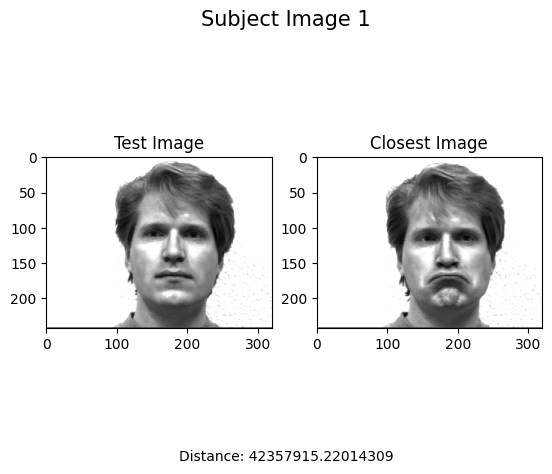

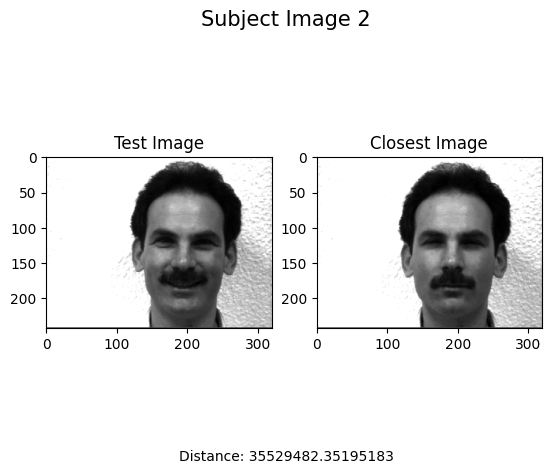

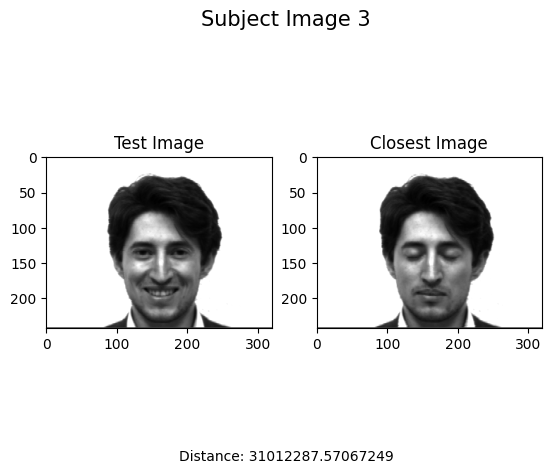

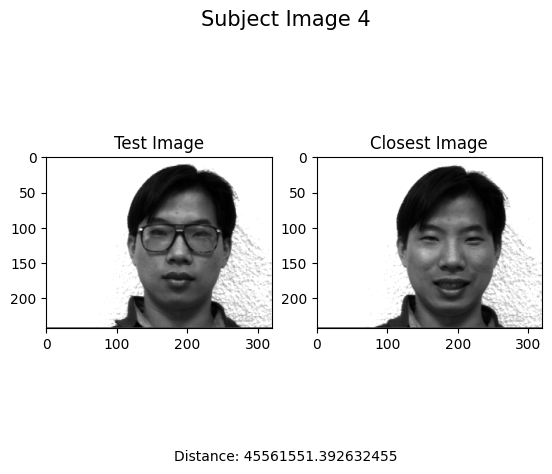

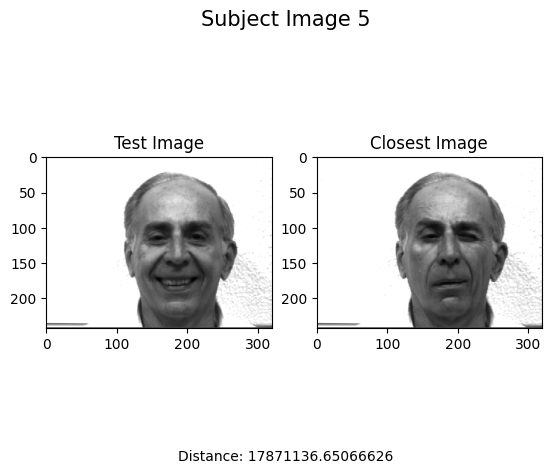

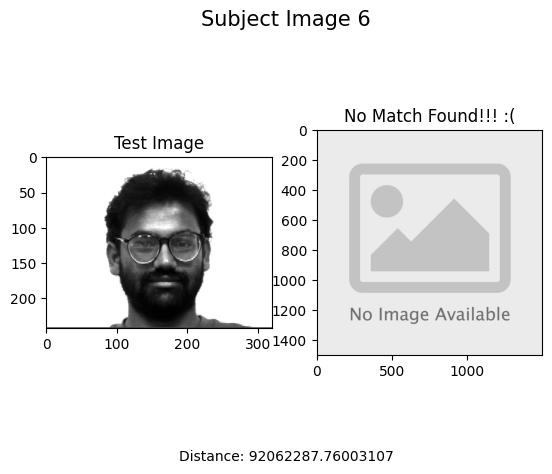

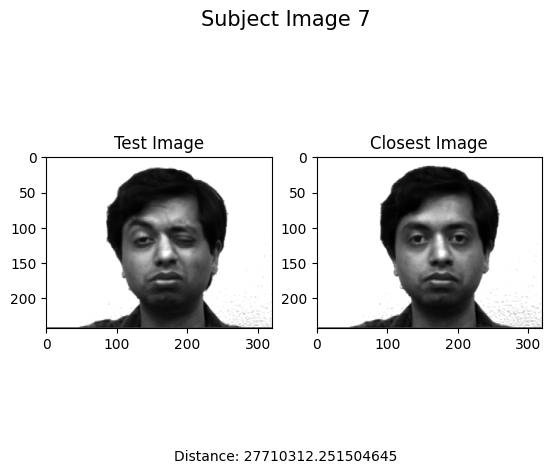

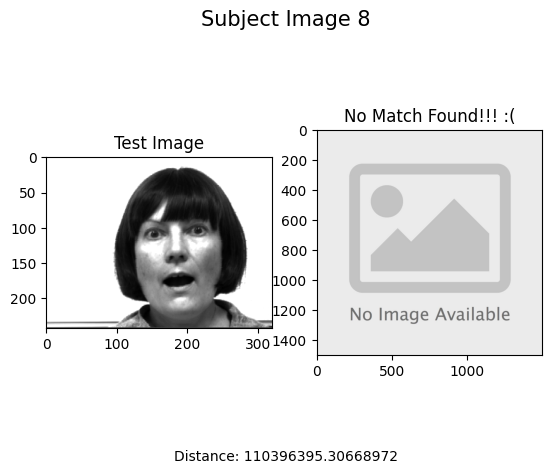

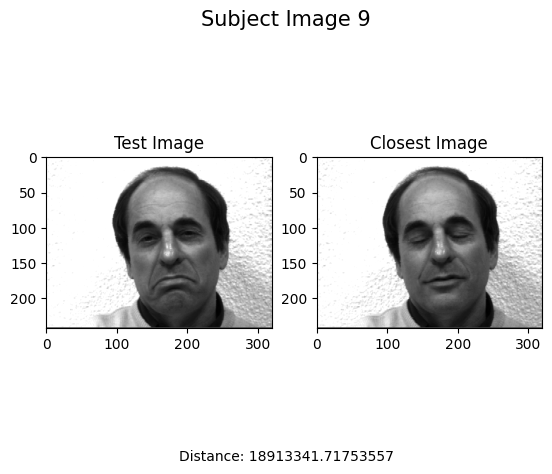

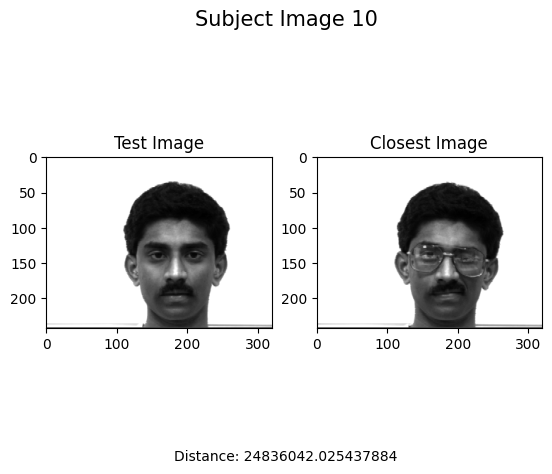

In [12]:
# Now we compute the euclidean distance between the test images and the training images
# and find the minimum distance

number_of_test_images = len(test_images_in_new_space)
THRESHOLD = 60_000_000
no_image_placeholder = glob.glob(path + "/dataset/no_image_placeholder.jpg")[0]
no_image_placeholder = mpimg.imread(no_image_placeholder)

for index, test_image in enumerate(test_images_in_new_space):
    fig, ax = plt.subplots(1, 2)
    distances = []

    fig.suptitle("Subject Image {}".format(index + 1), fontsize=15)
    # find the closest image from the training set
    for i, train_image in enumerate(images_in_new_space):
        distance = np.linalg.norm(train_image - test_image)
        distances.append(distance)

    # find the index of the minimum distance
    minimum_distance = min(distances)
    minimum_distance_index = distances.index(minimum_distance)

    # plot the image
    ax[0].imshow(test_images[index], cmap="gray")
    ax[0].set_title("Test Image")

    # if distance is within the acceptable threshold, plot the closest image
    if minimum_distance < THRESHOLD:
        ax[1].imshow(images[minimum_distance_index], cmap="gray")
        ax[1].set_title("Closest Image")
    else:

        ax[1].imshow(no_image_placeholder, cmap="gray")
        ax[1].set_title("No Match Found!!! :(")

    # in the figure display the distance
    fig.text(0.5, 0.04, "Distance: {}".format(minimum_distance), ha="center", fontsize=10)

    plt.show()

## Accuracy
From 11 test images, which contained 10 subjects that are actually in the training set and 1 subject that is not in the training set, the algorithm was able to correctly identify 9 of them.

It identified the subject that is not in the training set and returned Couldn't find the image.
On the other hand it returned can't find matching image for 2 images, although they were found in the training set, because their minimum euclidean distance was higher than the threshold. The accuracy of the algorithm is 81%.

> Accuracy: 0.81 (81%)

# Fisherfaces Face Recognition


In [13]:
import glob
import os
import numpy as np
from collections import defaultdict
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from collections import Counter

## Read Images

Load the training images from training dataset.

In [14]:
path_to_images = "/dataset/train_images/*.*.jpg"  # path to the training images
path = os.getcwd()
images_path =  glob.glob(path + path_to_images)

IMG_CLASS = defaultdict(list)
LABELS = {}

for idx, image_name in enumerate(images_path):
    person_name = image_name.split("/")[-1].split("\\")[-1].split(".")[0]
    IMG_CLASS[person_name].append(idx)
    LABELS[idx] = person_name

raw_images = [mpimg.imread(file) for file in images_path]

## Crop Images
Resize images to make them N X N, where N is 130.

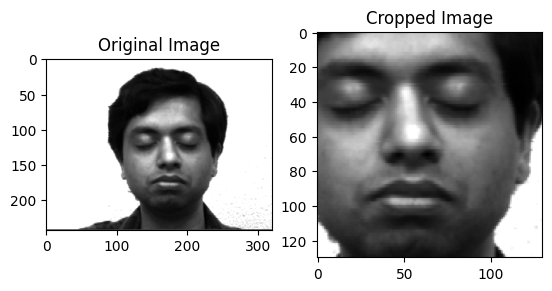

Original Dimension (130, 130)
Cropped Dimension (130, 130)


In [16]:
# crop the images into an N x N square
dimensions = (80, 210, 120, 250)
startx, endx, starty, endy = dimensions

# crop the images
images = [image[startx:endx, starty:endy] for image in raw_images]

# cropped image
# make room for all the images
fig, ax = plt.subplots(1, 2)

random_image = np.random.randint(0, len(raw_images))

# plot the original image
ax[0].imshow(raw_images[random_image], cmap="gray")
ax[0].set_title("Original Image")

# plot the cropped image
ax[1].imshow(images[random_image], cmap="gray")
ax[1].set_title("Cropped Image")

# display the plot
plt.show()

print("Original Dimension", images[0].shape)
print("Cropped Dimension", images[0].shape)

# from now on we'll work on the cropped images
images = np.array(images)

In [17]:

def show_images(images):
    fig, ax = plt.subplots(len(IMG_CLASS), 10, figsize=(20, 20))

    for row, person in enumerate(IMG_CLASS):
        row -= 1
        for idx in IMG_CLASS[person]:
            image = images[idx]

            idx %= 10
            ax[row][idx].imshow(image.reshape(130, 130), cmap="gray")
            ax[row][idx].set_title(person)
            ax[row][idx].axis("off")

    plt.show()

## Flatten the images

In [18]:

flattend_images = [np.array(image).flatten() for image in images]
flattend_images = np.array(flattend_images)

print("Dimension of the flattened image: ", flattend_images.shape)

Dimension of the flattened image:  (100, 16900)


## Compute the average face for all persons

In [19]:
# computing the average face for all images
avg_face = np.mean(flattend_images, axis=0)

# Compute average face for each person

In [20]:
class_mean = {}

# for each person calculate the mean face
for person in IMG_CLASS:
    person_images = []
    for idx in IMG_CLASS[person]:
        person_images.append(images[idx].flatten())

    class_mean[person] = np.mean(person_images, axis=0)

## Subtract the mean person face from each image

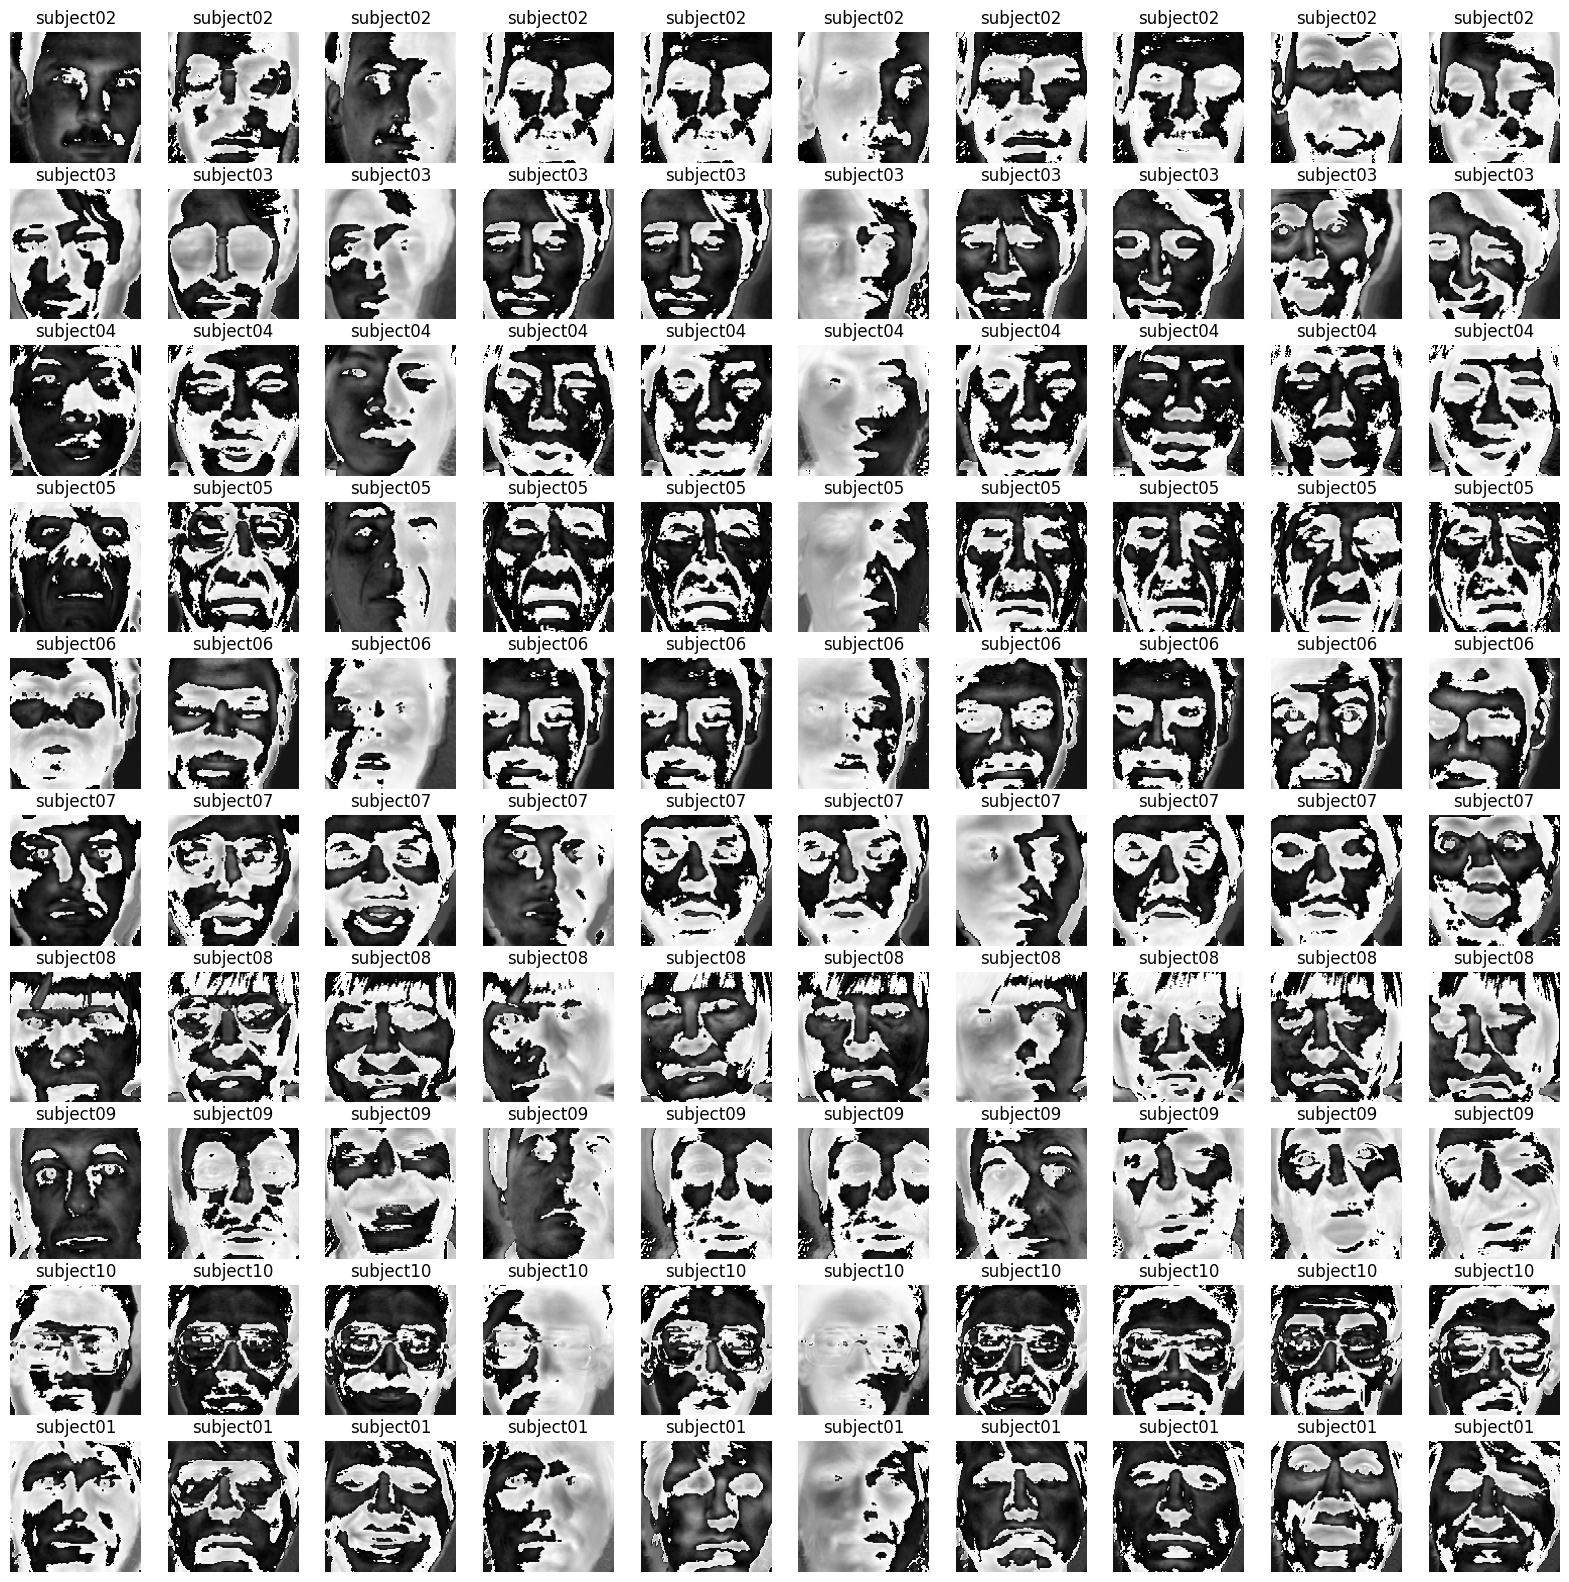

In [21]:

for person_name in IMG_CLASS:
    for img_idx in IMG_CLASS[person_name]:
        flattend_images[img_idx] = flattend_images[img_idx] - class_mean[person_name]

show_images(flattend_images)

## Calculate per person (per class) scatter matrices

In [22]:
def calc_scatter_mat(images, class_mean, avg_face):
    Sw = np.zeros((images.shape[1], images.shape[1]))
    Sb = np.zeros((images.shape[1], images.shape[1]))

    for person in IMG_CLASS:
        scatter_val = np.zeros((images.shape[1], images.shape[1]))

        for idx in IMG_CLASS[person]:
            image = images[idx]
            scatter_val += np.dot(image, image.T)
        
        Sw += scatter_val
        mean_scatter_val = class_mean[person] - avg_face
        Sb += np.dot(mean_scatter_val, mean_scatter_val.T) * len(IMG_CLASS[person])

    return Sw, Sb


Sw, Sb = calc_scatter_mat(images, class_mean, avg_face)
print("Sw shape: {}, Sb shape: {}".format(Sw.shape, Sb.shape))


Sw shape: (130, 130), Sb shape: (130, 130)


## Solving The Problem

In [23]:
# matrix for holding s_w^-1 * s_b
problem = np.linalg.inv(Sw.T).dot(Sb.T)

U, S, _ = np.linalg.svd(problem)

print(f'Shape of the decomposed vectors : {U.shape}')

# put the eigenvectors and eigenvalues in pair : (eigenvalue , eigenvector)
eigen_pairs = [(np.abs(S[i]), U[:, i]) for i in range(len(S))]

# sort the eigenpairs
eigen_pairs.sort(key=lambda element: element[0], reverse=True)

Shape of the decomposed vectors : (130, 130)


## K Significant Eigenfaces

In [24]:
# sum of the total eigen values
total = np.array([pair[0] for pair in eigen_pairs])
total = total.sum()


# select the importat eigenvector
selectedVectors = np.array([eigen_pairs[i][1] for i in range(len(eigen_pairs))])

print(f'Shape of selected K components : {selectedVectors.shape}')

Shape of selected K components : (130, 130)


## Project test images onto the LDA subspace

In [26]:
images_in_lda_space = np.dot(images, selectedVectors.T)

## Testing / Recognizing new Images
For fisherfaces, we use the nearest neighbor classifier with Euclidean distance metric to recognize new faces.

In [28]:
test_images = glob.glob(path + "/dataset/test_images/*.*.jpg")

actual_test_image_label = {}

for idx, image_name in enumerate(test_images):
    person_name = image_name.split("/")[-1].split("\\")[-1].split(".")[0]
    actual_test_image_label[idx] = person_name

test_images = [mpimg.imread(file) for file in test_images]
print("Number of test images: ", len(test_images))

test_images_cropped = [image[startx:endx, starty:endy] for image in test_images]
test_images_flattened = [image.flatten() for image in test_images_cropped]
test_images_flattened = np.array(test_images_flattened)

flattened_avg_face  = avg_face.flatten()
test_images_normalized = test_images_flattened - flattened_avg_face

test_images_in_new_space = np.dot(test_images_normalized, selectedVectors.T.flatten())

Number of test images:  10


In [29]:
testIndex = 0
correct = 0

for testFace in test_images_in_new_space:
    differences = images_in_lda_space - testFace
    euclideanDistances = np.linalg.norm(differences, axis=1)
    maxDist = np.max(euclideanDistances)
    euclideanDistances = euclideanDistances.tolist()

    # Arrange the distances in increasing order
    arrangedDistances = sorted(euclideanDistances)

    # Select the nearest neighbor
    neighbors = 1
    selectedDistances = arrangedDistances[:neighbors]
    selectedLabels = [LABELS[euclideanDistances.index(distance)] for distance in selectedDistances]

    # Find the majority label
    labelCounts = Counter(selectedLabels)
    predictedName = max(labelCounts, key=labelCounts.get)

    # Get the actual label
    actualName = actual_test_image_label[testIndex]

    if predictedName == actualName:
        correct += 1
    
    testIndex += 1

accuracy = correct / (testIndex + 1)
print(f'Accuracy: {accuracy}, {accuracy * 100}%')

Accuracy: 0.09090909090909091, 9.090909090909092%
